# Searching for objects in mock images from the ArcsFinding Challenge

The challenge is proposed by the Bologna group, http://metcalf1.bo.astro.it/blf-portal/gg_challenge.html .

I have here, now, a small set of images to play with. And I will choose one to scratch the problem.

In [1]:
ls data

imageEUC_VIS-100002.fits  imageEUC_VIS-100010.fits  imageEUC_VIS-100014.fits  imageEUC_VIS-101843.fits  imageEUC_VIS-104135.fits
imageEUC_VIS-100003.fits  imageEUC_VIS-100013.fits  imageEUC_VIS-100019.fits  imageEUC_VIS-101846.fits


In [2]:
# filename = 'data/imageEUC_VIS-100003.fits'
filename = 'data/imageEUC_VIS-100003.fits'

Load some libraries...

In [3]:
import astropy
import skimage
# import mahotas
import pandas
import numpy
import booq

np = numpy

pandas.set_option('display.max_columns',10)
pandas.set_option('display.width',100)

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [5]:
from astropy.io import fits
img = fits.open(filename)[0].data
del filename

<IPython.core.display.Javascript object>


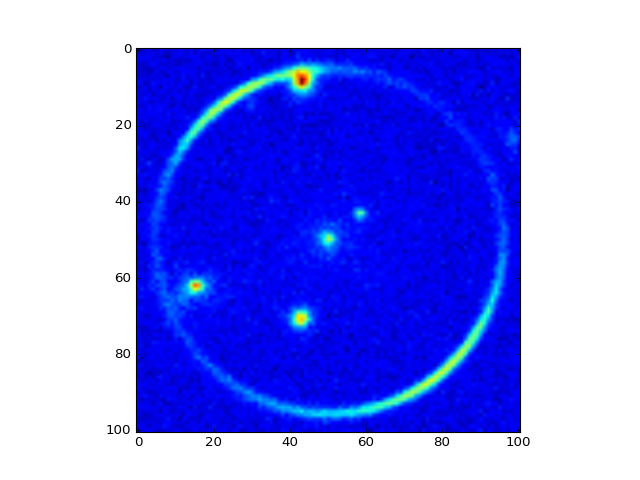

In [7]:
plt.imshow(img)#,cmap='Blues_r')

### Intensity distribution

In [8]:
def simple(hist,bins,vmarks=[],log=False,xlabel='X',ylabel='#', ax=None):
    """
    Plot histogram with vertical line marks

    Output:
     - plt  : pyplot object. plt.show() will give you the histogram.

    """
    from matplotlib import pyplot as plt
    if ax is None:
        fig,ax = plt.subplots()
    else:
        ax = plt
    width = 0.7*(bins[1]-bins[0])
    centers = (bins[:-1]+bins[1:])/2.
    ax.grid(True)
    ax.bar(centers, hist, width=width, align='center', color='g', log=log, alpha=0.9)
    try:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    except:
        ax.xlabel(xlabel)
        ax.ylabel(ylabel)

    ymax = hist.max()*1.01
    ymin = -ymax/50.

    for i,iv in enumerate(vmarks):
        ymaxn = ymax + i%2*(ymin*2)
        ax.vlines(iv,ymin,ymaxn,color='r')
        ax.text(iv,ymaxn,"%.1f"%(iv))

    return ax

def imhist(img,bins=100,vmarks=[],log=False,xlabel='X',ylabel='#', ax=None):
    """
    Plot histogram from image array
    #TODO This function should not remain here.
    
    Output:
     - plt  : pyplot object. plt.show() will give you the histogram.
    
    """
    
    hist,bins = np.histogram(img.flatten(),bins=bins,normed=True)
    
    return simple(hist,bins,vmarks,log,xlabel,ylabel,ax)

<IPython.core.display.Javascript object>


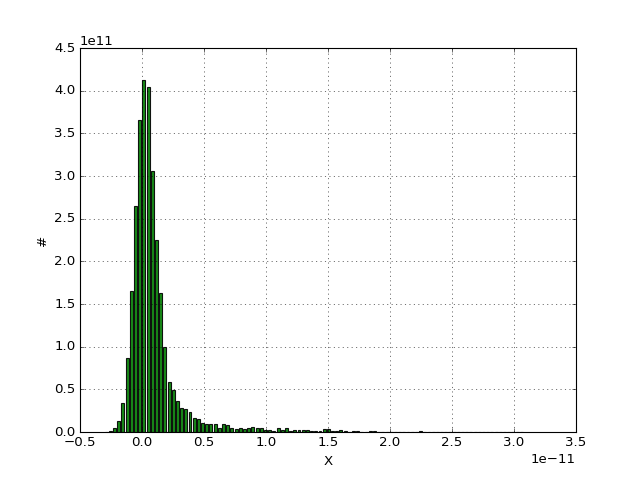

In [9]:
_ = imhist(img)

In [12]:
def normalize(img,unit=1):
    """
    Normalize 'img' to 'unit'
    """
    
    return unit * (img - img.min())/(img.max() - img.min())

img = normalize(img)

<IPython.core.display.Javascript object>


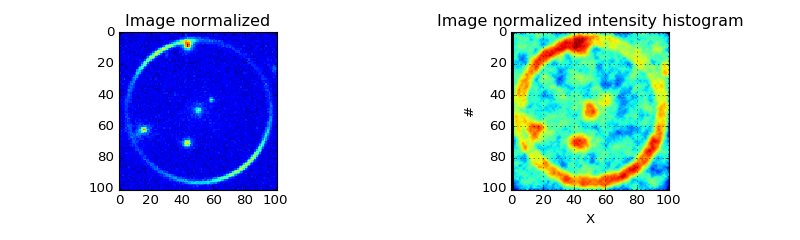

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img, interpolation='nearest')
ax[0].set_title('Image normalized')
_ = imhist(img,ax=ax[1])
ax[1].set_title('Image normalized intensity histogram')

fig.tight_layout()
plt.show()

## Pre-processing

### Entropy

In [14]:
from skimage.morphology import disk
from skimage.filters.rank import entropy

img_entr = entropy(img,disk(4))
img_entr = normalize(img_entr)
# plt.imshow(img_entr)

In [15]:
def equal(img,nbins=1000,savefig=True,figname='hist_equal.png'):
    """
    Equalizes given image histogram
    
    Input:
     - img ndarray : Image array
     - nbins int : Number of bins to use for equalization
    
    Output:
     - img_eq  ndarray : Image array equalized
    
    ---
    """
    
    imhist,bins = np.histogram(img.flatten(),nbins,normed=True)
    cdf = np.cumsum(imhist)
    cdf = cdf/cdf[-1]
    imgterp = np.interp(img.flatten(),bins[:-1],cdf)
    img_eq = imgterp.reshape(img.shape)
    
    return img_eq;

# img_entr = equal(img_entr)

<IPython.core.display.Javascript object>


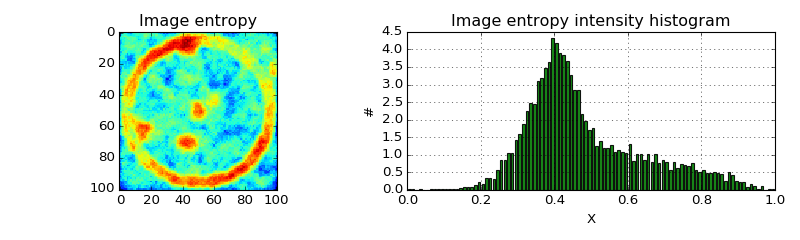

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_entr, interpolation='nearest')
ax[0].set_title('Image entropy')
_ = imhist(img_entr,ax=ax[1])
ax[1].set_title('Image entropy intensity histogram')

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


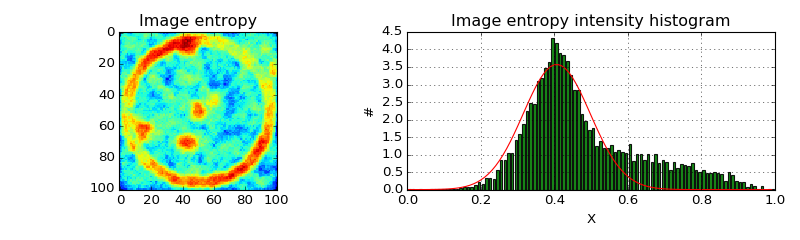

In [17]:
def func_gauss(t, a, b, k):
    from numpy import exp
    return a * exp(-b*(t-k)**2)

def fit_curve(x,y,fit_func):
    from numpy import linspace
    from scipy.optimize import curve_fit

    popt,pcov = curve_fit(fit_func, x, y)
    x = linspace(x.min(),x.max(),100)
    y = fit_func(x,*popt)
    return x,y,popt

import numpy as np
hist,bins = np.histogram(img_entr.flatten(),bins=100,normed=True)

x_fit, y_fit, popt = fit_curve( bins[:-1], hist, func_gauss )

# plt.plot( x_fit, y_fit, linestyle='solid', color='red', lw=1 )
# plt.plot( bins[:-1], hist, linestyle='solid', color='red', lw=1 )

fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_entr, interpolation='nearest')
ax[0].set_title('Image entropy')
_ = imhist(img_entr,ax=ax[1])
ax[1].set_title('Image entropy intensity histogram')
ax[1].plot( x_fit, y_fit, linestyle='solid', color='red', lw=1 )
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


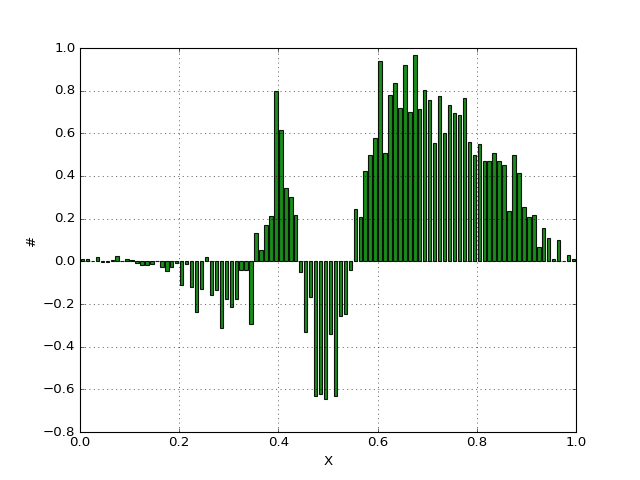

In [18]:
# Now I want to subtract the gaussian from histogram
gauss_disc = func_gauss(bins[:-1],*popt)

_diff = hist-gauss_disc
_ = simple(_diff,bins)

<IPython.core.display.Javascript object>


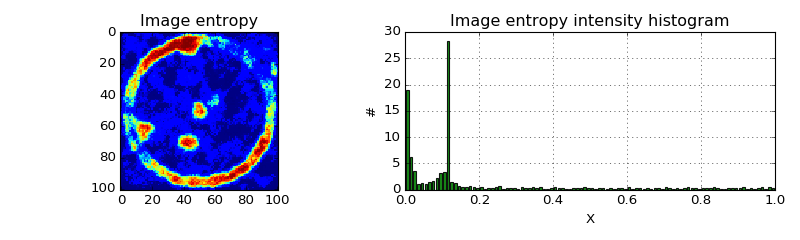

In [19]:
_diff[np.where(_diff<0)] = 0
cdf = np.cumsum(_diff)
cdf = cdf/cdf[-1]
imgterp = np.interp(img_entr.flatten(),bins[:-1],cdf)
img_eq = imgterp.reshape(img_entr.shape)

fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_eq, interpolation='nearest')
ax[0].set_title('Image entropy')
_ = imhist(img_eq,ax=ax[1])
ax[1].set_title('Image entropy intensity histogram')

fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


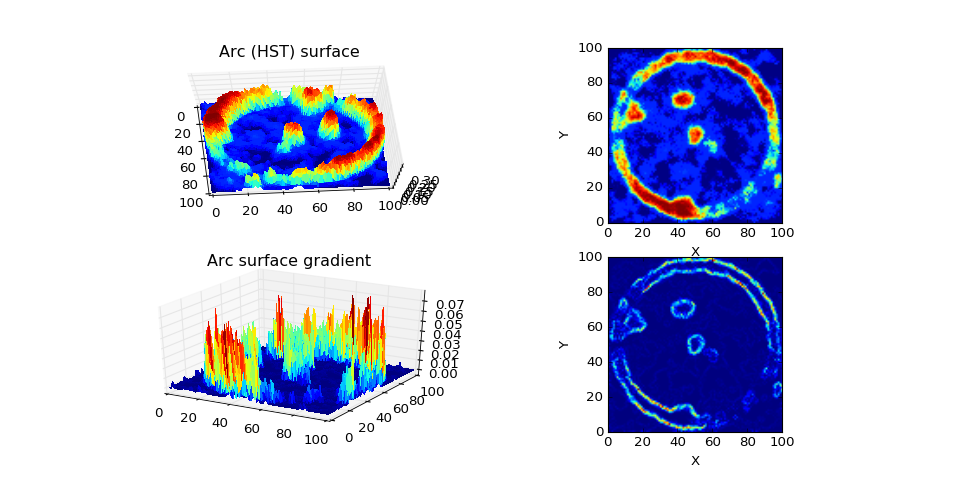

In [24]:
def grad(img):
    """
    Return image gradiente (module^2) array
    """
    gx,gy = np.gradient(img)
    grad_img = gx**2 + gy**2
    return grad_img

from matplotlib import cm
def prof_33D(img):

    x,y = img.shape
    x = np.arange(0,x)
    y = np.arange(0,y)
    X,Y = np.meshgrid(x,y)
    extent = (X.min(), X.max(), Y.min(), Y.max())
    
    # Twice as wide as it is tall.
    fig = plt.figure(figsize=plt.figaspect(0.5))
    
    S = np.log10(img+1)
    s_min = S.min()
    s_max = S.max()
    ds = (s_max-s_min)/20
    
    Z = grad(img)**2
    Z = np.log10(np.sqrt(Z)+1)
    z_min = Z.min()
    z_max = Z.max()
    dz = (z_max-z_min)/20
    
    #---- First subplot - 3D
    ax = fig.add_subplot(2, 2, 1, projection='3d')    
    surf = ax.plot_surface(X, Y, S, rstride=1, cstride=1, cmap=cm.jet, linewidth=0, antialiased=False)
    ax.set_zlim3d(s_min-ds, s_max+ds)
    ax.set_title('Arc (HST) surface')
    
    #---- Second subplot - 2D
    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(S[::-1,:],extent=extent)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #fig.colorbar(surf, shrink=0.5, aspect=5)    
    

    #---- First subplot
    ax = fig.add_subplot(2, 2, 3, projection='3d')    
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0, antialiased=False)
    ax.set_zlim3d(z_min-dz, z_max+dz)
    ax.set_title('Arc surface gradient')

    #---- Second subplot
    ax = fig.add_subplot(2, 2, 4)
    ax.imshow(Z[::-1,:],extent=extent)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')


    return plt

_ = prof_33D(img_eq)

### Smoothing

In [11]:
def gaussian(img, sigma=[3,3]):
    """
    Simple gaussian filter
    
    Input:
     - img <ndarray>
     - sigma <[int,int]> : sigma window
    
    Output:
     - <ndarray>
    
    ---
    """
    import scipy.ndimage as ndi
    return ndi.gaussian_filter(img,sigma);

img_smooth = gaussian(img,[2,2])

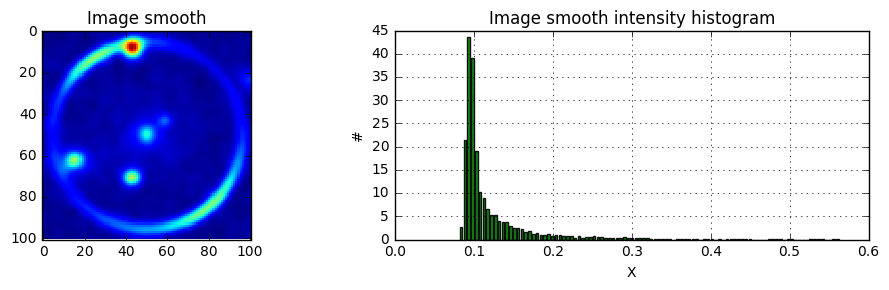

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_smooth, interpolation='nearest')
ax[0].set_title('Image smooth')
_ = imhist(img_smooth,ax=ax[1])
ax[1].set_title('Image smooth intensity histogram')

fig.tight_layout()
plt.show()

In [13]:
# Thresholding
def histmax(img):
    """
    Maximum histogram value for threshold estimation
    """
    np = numpy
    
    nbins=1000
    imhist,bins = np.histogram(img.flatten(),nbins,normed=True);

    return bins[np.argmax(imhist)] + np.std(img)

# --

def riddler_calvard(img):
    """
    Riddler-Calvard method for image thrashold (fg|bg) estimation
    """
    import mahotas
    
    return mahotas.thresholding.rc(img)

# --

def otsu(img):
    """
    Otsu method for image thrashold (fg|bg) estimation
    """
    import mahotas
    
    return mahotas.thresholding.otsu(img)

def float2uint(img):
    """
    Normalize and truncate 'img' values to uint8 scale [0:255]
    """
    np = numpy;
    
    img = normalize(img) * 255.
    u_img = img.astype(np.uint8)
    
    return u_img

In [14]:
_img = img
th_mx = histmax(_img[np.where(_img)])
img_uint8 = float2uint(_img)
th_rc = float(riddler_calvard(img_uint8) - img_uint8.min())/(img_uint8.max()-img_uint8.min())
th_ot = float(otsu(img_uint8) - img_uint8.min())/(img_uint8.max()-img_uint8.min())
print ' Histmax: {}\n R.Calvard: {}\n Otsu: {}'.format(th_mx,th_rc,th_ot)
th_mean = (th_mx*0.7+th_rc*0.15+th_ot*0.15)
print 'Mean: {}'.format(th_mean)

 Histmax: 0.180240055775
 R.Calvard: 0.246863483575
 Otsu: 0.247058823529
Mean: 0.200256385108


### Finding contours

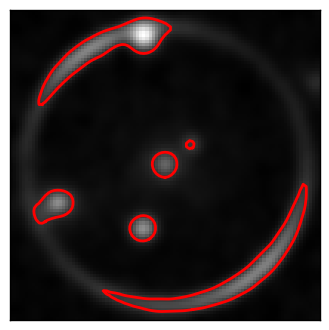

In [15]:
from skimage import measure
contours = measure.find_contours(img_smooth,th_mx)

fig, ax = plt.subplots()
ax.imshow(img_smooth, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Finding local maxima

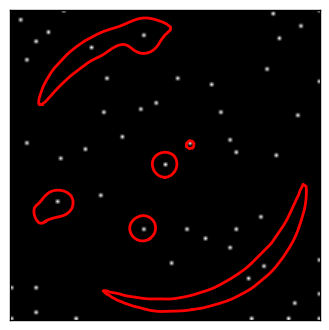

In [16]:
from skimage.feature import peak_local_max
local_maxi = peak_local_max(img_smooth, min_distance=2, exclude_border=False, indices=False)

fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [17]:
def create_mask(img,contours):
    def define_regions(contours):
        '''
        Return a list of regions (~matplotlib.path.Path), for each entry in 'country_map'

        'country_map' is expected to provide columns 'lons' and 'lats',
        providing lists of coordinates defining the respective country
        as polygon(s). If 'country_map' has multiple lines, multiple
        "Paths" will be created (for each line/polygon).
        '''
        from matplotlib.path import Path
        import numpy as np
        regions_path = []
        for n, contour in enumerate(contours):
            regions_path.append( Path( contour ) )
        return regions_path

    # Create vertex coordinates for each grid cell...
    # (<0,0> is at the top left of the grid in this system)
    ny,nx = img.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x, y = x.flatten(), y.flatten()

    grid = np.vstack((y,x)).T

    mask = np.zeros(img.shape).astype(bool)
    paths = define_regions(contours)
    for path in paths:
        _mask = path.contains_points(grid)
        mask = mask + _mask.reshape((ny,nx))
    return mask

mask = create_mask(img_smooth,contours)

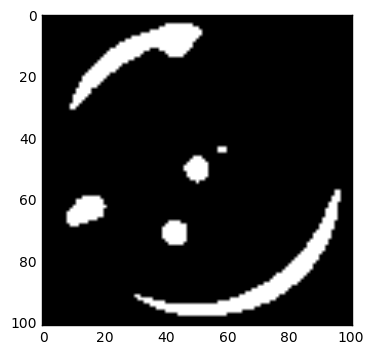

In [18]:
plt.imshow(mask, cmap='gray')

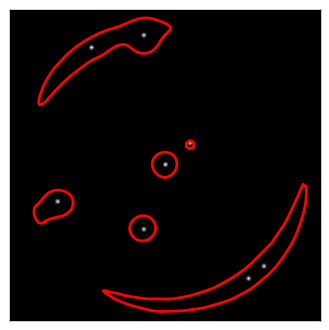

In [19]:
from skimage.feature import peak_local_max
local_maxi = peak_local_max(img_smooth*mask, min_distance=2, exclude_border=False, indices=False)

fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [20]:
def region_growing(img,x,y,thresh):
    """
    Segment using a Region Growing algorithm
    
    Input:
     - img  ndarray : Image array (ndim=2)
     - x        int : Seed x position
     - y        int : Seed y position
     - thresh float : Threshold value for limiting the grow
    
    Output:
     - region  : Region grown around given 'x,y'
    
    ---
    """
    from scipy import ndimage as ndi
    
    x_o = x
    y_o = y
    flag = True

#     logging.debug("RG seed: X(%d) Y(%d)",x_o,y_o)
#     logging.debug("Threshold: %.2f",thresh)

    # Initialize region with the seed point
    region = np.zeros(img.shape,dtype=np.bool)
    reg_old = (region==flag)

#     logging.debug("Image seed point value: %.2f",img[y_o,x_o])
    if (img[y_o,x_o] < thresh): return region
    
    region[y_o,x_o] = flag
    reg_cur = (region==flag)

    # For future (loop) morphological operations...
    strct_elem = ndi.generate_binary_structure(2,2)

    # While region stills changes (grow), do...
    while not np.all(region == reg_old):
        
        reg_old = region.copy()

        # Define pixel neighbours
        tmp = ndi.binary_dilation(region,strct_elem, 1)
        neigbors = tmp - region
        inds = np.where(neigbors)

        # Check for the new neighbors; do they fullfil requirements?
        #region[np.where(region[inds]>=thresh)] = flag
        for y_i,x_i in zip(*inds):
            if (img[y_i,x_i] >= thresh):
                region[y_i,x_i] = flag

    return region

/anaconda/envs/booq/lib/python2.7/site-packages/ipykernel/__main__.py:45: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


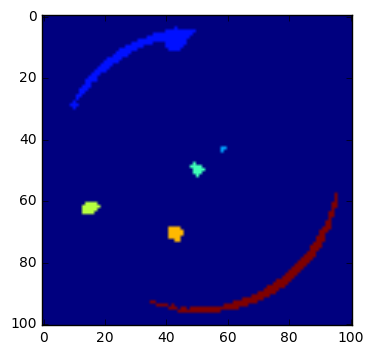

In [21]:
local_maxi = peak_local_max(img_smooth*mask, min_distance=2, exclude_border=False, indices=True)

fig, ax = plt.subplots()
img_reg = np.zeros(img.shape,dtype=int)
for n,local_max in enumerate(local_maxi):
    xy = local_maxi[n]
    y,x = xy
    reg = region_growing(img,x,y,th_mx+0.1)

    _img = reg.astype(int) * n
    _idx = np.where(reg)
    img_reg[_idx] = _img[_idx]
    
_ = ax.imshow(img_reg)

In [22]:
img_mask = img*mask
img_mask = equal(img_mask)
img_mask_smooth = gaussian(img_mask,[1,1])

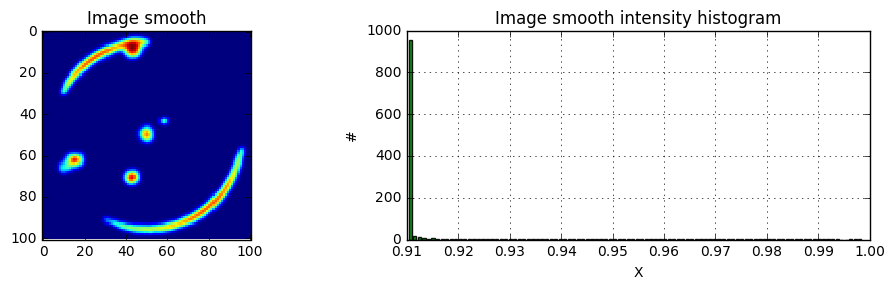

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharex=False, sharey=False,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img_mask_smooth, interpolation='nearest')
ax[0].set_title('Image smooth')
_ = imhist(img_mask_smooth,ax=ax[1])
ax[1].set_title('Image smooth intensity histogram')

fig.tight_layout()
plt.show()

In [24]:
local_maxi = peak_local_max(img_mask_smooth, exclude_border=False, indices=False)

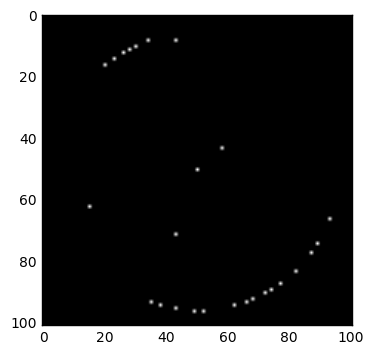

In [25]:
fig, ax = plt.subplots()
ax.imshow(local_maxi, cmap=plt.cm.gray)

In [26]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max
# distance = ndi.distance_transform_edt(mask)
# local_maxi = peak_local_max(distance, indices=False,labels=mask)
markers = ndi.label(local_maxi)[0]
labels = watershed(-img_mask_smooth, markers, mask=mask)

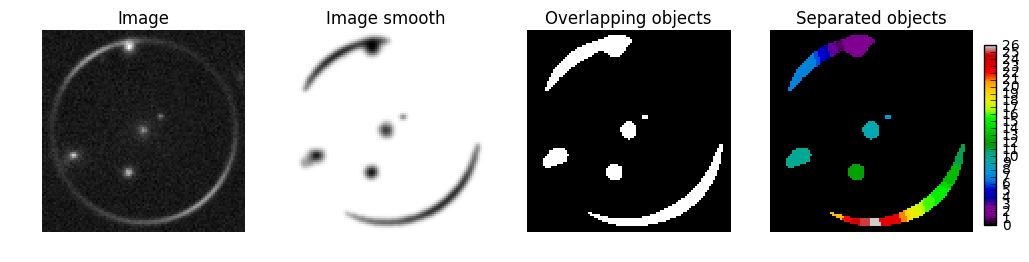

In [27]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Image')

ax[1].imshow(-img_mask_smooth, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Image smooth')

ax[2].imshow(mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Overlapping objects')

im = ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest')
ax[3].set_title('Separated objects')

cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
vals = np.unique(labels)
fig.colorbar(im, cax=cax, ticks=vals)#,values=vals)

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.show()

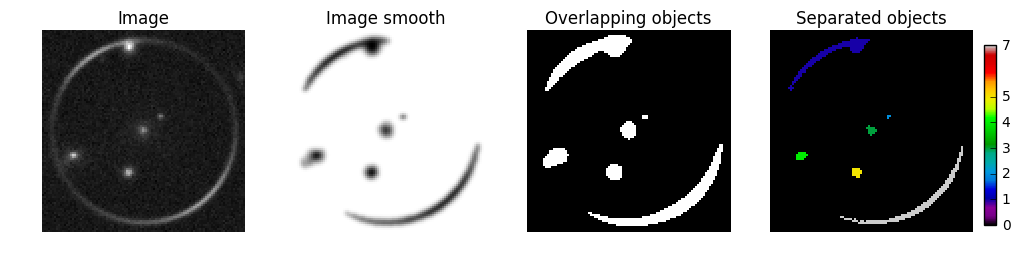

In [28]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

_ = ax[0].imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Image')

_ = ax[1].imshow(-img_mask_smooth, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Image smooth')

_ = ax[2].imshow(mask, cmap=plt.cm.gray, interpolation='nearest')
ax[2].set_title('Overlapping objects')

im = ax[3].imshow(img_reg, cmap=plt.cm.spectral, interpolation='nearest')
ax[3].set_title('Separated objects')

cax = fig.add_axes([0.91, 0.2, 0.01, 0.6])
vals = np.unique(img_reg)
# fig.colorbar(im, cax=cax, values=vals, ticks=vals)
fig.colorbar(im, cax=cax, ticks=vals)

for a in ax:
    a.set_axis_off()

# fig.tight_layout()
plt.show()

## Regions properties

In [29]:
from skimage.measure import regionprops
# reg_props = regionprops(img_reg,img_smooth)
reg_props = regionprops(labels,img_smooth)


d_props = {}
l_props = []
d2_props = {}
l2_props = []
for props in reg_props:
    label = props.label
    vals = []
    vals2 = []
    for prop in props:
        val = props[prop]
        if np.isscalar(val):
            vals.append(val)
            l_props.append(prop)
        else:
            if isinstance(val,np.ndarray):
                val = val.shape
            vals2.append(val)
            l2_props.append(prop)
    d_props[label] = vals
    d2_props[label] = vals2

index = l_props[:len(vals)]
df = pandas.DataFrame(d_props,index=index)#.transpose()

index = l2_props[:len(vals2)]
df2 = pandas.DataFrame(d2_props,index=index)#.transpose()

In [30]:
df

,1,2,3,4,5,...,22,23,24,25,26
area,18.000000,128.000000,28.000000,15.000000,23.000000,...,11.000000,47.000000,15.000000,20.000000,18.000000
convex_area,21.000000,134.000000,31.000000,17.000000,25.000000,...,11.000000,53.000000,16.000000,20.000000,19.000000
eccentricity,0.828532,0.689855,0.767676,0.955077,0.881423,...,0.755929,0.891798,0.758745,0.612372,0.616606
equivalent_diameter,4.787307,12.766153,5.970821,4.370194,5.411516,...,3.742410,7.735778,4.370194,5.046265,4.787307
euler_number,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
extent,0.642857,0.727273,0.700000,0.714286,0.718750,...,0.733333,0.712121,0.750000,1.000000,0.900000
filled_area,18.000000,128.000000,28.000000,15.000000,23.000000,...,11.000000,47.000000,15.000000,20.000000,18.000000
label,1.000000,2.000000,3.000000,4.000000,5.000000,...,22.000000,23.000000,24.000000,25.000000,26.000000
major_axis_length,6.606674,15.226680,7.606141,7.921806,7.944064,...,4.512609,11.746158,5.563690,5.656854,5.412761
max_intensity,0.283971,0.562848,0.318563,0.327582,0.331990,...,0.196657,0.253751,0.206904,0.217817,0.220684


In [31]:
print df2

                                                         1                               2   \
bbox                                        (5, 33, 12, 37)                 (3, 36, 14, 52)   
centroid                                        (8.0, 34.5)         (7.4296875, 43.1640625)   
convex_image                                         (7, 4)                        (11, 16)   
coords                                              (18, 2)                        (128, 2)   
filled_image                                         (7, 4)                        (11, 16)   
image                                                (7, 4)                        (11, 16)   
moments                                              (4, 4)                          (4, 4)   
moments_central                                      (4, 4)                          (4, 4)   
moments_hu                                             (7,)                            (7,)   
moments_normalized                                

### Erosion

What about eroding the labels/regions? Instead of a cluster of pixels, I want a point or a line representing the object(s).

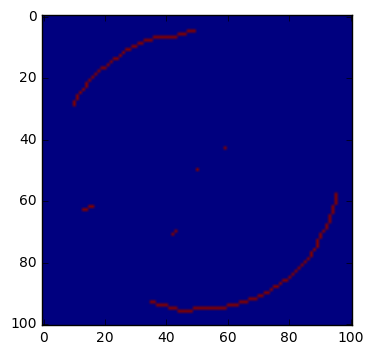

In [33]:
from skimage import morphology

_img = img_reg.copy()

lbls = list(np.unique(_img))
lbls.sort()
_ = lbls.pop(0)

img_erod = np.zeros(_img.shape,dtype=int)
for n in lbls:
    _mask = np.zeros(_img.shape,dtype=int)
    _mask[np.where(_img==n)] = 1
#     _mask = morphology.binary_erosion(_mask, morphology.disk(1))
#     _mask = morphology.medial_axis(_mask)
    _mask = morphology.skeletonize(_mask)
    img_erod += _mask

plt.imshow(img_erod)